# Kernelized Stein Gradient

This notebook accompanies the original blog post [here](https://www.sanyamkapoor.com/machine-learning/stein-gradient).

## Install Dependencies

We use [PyTorch](https://pytorch.org/) for all our differentiation needs and [Altair](https://altair-viz.github.io/) for plotting.

In [1]:
# Uncomment this if the imports throw an error
! pip install altair>=2.4 numpy>=1.16 torch>=1.0

In [27]:
import math
import numpy as np
import pandas as pd
import torch
import torch.autograd as autograd
import torch.optim as optim
import altair as alt
import corner
import matplotlib.pyplot as plt


alt.data_transformers.enable('default', max_rows=None)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Drawing Utilities

In [4]:
def get_density_chart(P, d=7.0, step=0.1):
  xv, yv = torch.meshgrid([
      torch.arange(-d, d, step),
      torch.arange(-d, d, step)
  ])
  pos_xy = torch.cat((xv.unsqueeze(-1), yv.unsqueeze(-1)), dim=-1)
  p_xy = P.log_prob(pos_xy.to(device)).exp().unsqueeze(-1).cpu()

  df = torch.cat([pos_xy, p_xy], dim=-1).numpy()
  df = pd.DataFrame({
      'x': df[:, :, 0].ravel(),
      'y': df[:, :, 1].ravel(),
      'p': df[:, :, 2].ravel(),
  })

  chart = alt.Chart(df).mark_point().encode(
    x='x:Q',
    y='y:Q',
    color=alt.Color('p:Q', scale=alt.Scale(scheme='viridis')),
    tooltip=['x','y','p']
  )

  return chart


def get_particles_chart(X):
  df = pd.DataFrame({
      'x': X[:, 0],
      'y': X[:, 1],
  })

  chart = alt.Chart(df).mark_circle(color='red').encode(
    x='x:Q',
    y='y:Q',
    opacity=alt.value(0.5)
  )

  return chart

## RBF Kernel

In these experiments, we will use the *rbf* kernel. The kernel is defined as the squared exponential distance between the two vectors, parametrized by a bandwidth argument $\sigma$.

$$
k_{rbf}(\mathbf{x}, \mathbf{x}^\prime) = \exp{-\frac{1}{2\sigma^2}||\mathbf{x}-\mathbf{x}^\prime||^2}
$$

A vectorized version of the  kernel is given below. A few notes on the implementation follow.

In [5]:
class RBF(torch.nn.Module):
  def __init__(self, sigma=None):
    super(RBF, self).__init__()

    self.sigma = sigma

  def forward(self, X, Y):
    XX = X.matmul(X.t())
    XY = X.matmul(Y.t())
    YY = Y.matmul(Y.t())

    dnorm2 = -2 * XY + XX.diag().unsqueeze(1) + YY.diag().unsqueeze(0)

    # Apply the median heuristic (PyTorch does not give true median)
    if self.sigma is None:
      np_dnorm2 = dnorm2.detach().cpu().numpy()
      h = np.median(np_dnorm2) / (2 * np.log(X.size(0) + 1))
      sigma = np.sqrt(h).item()
    else:
      sigma = self.sigma

    gamma = 1.0 / (1e-8 + 2 * sigma ** 2)
    K_XY = (-gamma * dnorm2).exp()

    return K_XY

# Let us initialize a reusable instance right away.
K = RBF()

Selecting the bandwidth parameter $\sigma$ may be a painful task in itself. A popular heuristic chosen in literature is the *median* heuristic where we choose the bandwidth to be

$$
\sigma^2 = \frac{median^2}{2 \log{(n + 1)}}
$$

the median among distance of all pairs. This allows for gradient contribution from all the pairs when computing the gradient of the kernel during simulation of the ODE. Note that we use the `numpy` median function because the PyTorch median function does not behave as expected when the number of elements are even (and does not return the mean of the two central elements).

## Stein Variational Gradient Descent

We now simulate the following ODE for each particle $x_j$ in the system.

$$
\dot{x}_j = \frac{1}{n} \sum_{j = 1}^n \left[ k(x_j, x) \nabla_{x_j} \log{p(x_j)} + \nabla_{x_j} k(x_j, x)  \right]
$$

For stability reasons, we use Adam to allow for adaptive step size during the simulation. In fact, this can be replaced by any of the adaptive gradient descent techniques.

This is encapsulated in the `step` function below.

In [6]:
class SVGD:
  def __init__(self, P, K, optimizer):
    self.P = P
    self.K = K
    self.optim = optimizer

  def phi(self, X):
    X = X.detach().requires_grad_(True)

    log_prob = self.P.log_prob(X)
    score_func = autograd.grad(log_prob.sum(), X)[0]

    K_XX = self.K(X, X.detach())
    grad_K = -autograd.grad(K_XX.sum(), X)[0]

    phi = (K_XX.detach().matmul(score_func) + grad_K) / X.size(0)

    return phi

  def step(self, X):
    self.optim.zero_grad()
    X.grad = -self.phi(X)
    self.optim.step()

# Experiments

## Unimodal Gaussian

We will first run this on a Unimodal Gaussian. We initialize the particles in an overdispersed manner and see how they converge around the typical set of the distribution.

**NOTE**: Try increasing the number of particles $n$ and different initializations to see how the particles distribute themselves.

In [ ]:
gauss = torch.distributions.MultivariateNormal(torch.Tensor([-0.6871,0.8010]).to(device),
        covariance_matrix=5 * torch.Tensor([[0.2260,0.1652],[0.1652,0.6779]]).to(device))

n = 1000
X_init = (14* torch.rand(n, *gauss.event_shape)-7).to(device)

In [8]:
gauss_chart = get_density_chart(gauss, d=7.0, step=0.1)

/home/usuario/Code/venv_gen/lib/python3.12/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Let us see how this overdispersed initialization looks like. Note that initializations much farther away from the typical set of the distributions may take longer to converge.

In [9]:
gauss_chart + get_particles_chart(X_init.cpu().numpy())

alt.LayerChart(...)

In [10]:
X = X_init.clone()
svgd = SVGD(gauss, K, optim.Adam([X], lr=1e-1))
for _ in range(1000):
    svgd.step(X)

In [11]:
gauss_chart + get_particles_chart(X.cpu().numpy())

alt.LayerChart(...)

## Mixture of Gaussians

The exact same simulation without any manual fine tuning works even for a multimodal Gaussian. We will first create a generic PyTorch distribution which can help us build multiple kinds of Mixture of Gaussians.

In [21]:
class MoG(torch.distributions.Distribution):
    """
    Mixture of Gaussians (MoG) distribution using PyTorch's Distribution module.
    """

    def __init__(self, loc, covariance_matrix, weights=None):
        """
        Args:
            loc (torch.Tensor): Shape (num_components, dim) - Mean vectors of Gaussian components.
            covariance_matrix (torch.Tensor): Shape (num_components, dim, dim) - Covariance matrices.
            weights (torch.Tensor, optional): Shape (num_components,) - Mixing coefficients (must sum to 1).
        """
        self.num_components = loc.shape[0]  # Number of Gaussian components
        self.dim = loc.shape[1]  # Dimensionality of the distribution
        # Define Gaussian components
        self.components = torch.distributions.MultivariateNormal(loc, covariance_matrix=covariance_matrix)

        # Define mixture weights (uniform if not provided)
        if weights is None:
            self.weights = torch.ones(self.num_components, device=loc.device) / self.num_components
        else:
            self.weights = weights / weights.sum()  # Normalize weights to sum to 1

        # Define a categorical distribution for component selection
        self.mixture_dist = torch.distributions.Categorical(self.weights)

        # Initialize parent class with correct batch and event shape
        batch_shape = torch.Size([])
        event_shape = torch.Size([self.dim])
        super().__init__(batch_shape=batch_shape, event_shape=event_shape)

    def log_prob(self, value):
        """
        Compute log probability of `value` under the mixture model.
        """
        # Compute log probabilities for each Gaussian component
        log_probs = self.components.log_prob(value.unsqueeze(-2))  # Shape: (*, num_components)

        # Compute mixture log probabilities using log-sum-exp trick
        weighted_log_probs = log_probs + torch.log(self.weights)
        return torch.logsumexp(weighted_log_probs, dim=-1)

    def sample(self, sample_shape=torch.Size([])):
        """
        Generate samples from the Mixture of Gaussians.
        """
        # Sample component indices
        component_indices = self.mixture_dist.sample(sample_shape)

        # Select component parameters
        selected_means = self.components.loc[component_indices]
        selected_covs = self.components.covariance_matrix[component_indices]

        # Sample from selected Gaussians
        return torch.distributions.MultivariateNormal(selected_means, covariance_matrix=selected_covs,validate_args=False,).sample()

### Mixture of Two Gaussians

Here we create a mixture of two Gaussians where the means are symmetrically placed at $x=|5|$ and the covariance matrix is given by $\begin{pmatrix}0.5 & 0 \\ 0 & 0.5\end{pmatrix}$.

In [28]:
class MoG2(MoG):
    def __init__(self, device=None):
        loc = torch.tensor([[-5.0, 0.0], [5.0, 0.0]], device=device)
        cov = torch.diag_embed(torch.tensor([0.5, 0.5], device=device)).repeat(2, 1, 1)
        super().__init__(loc, cov)


mog2 = MoG2(device=device)

/home/usuario/Code/venv_gen/lib/python3.12/site-packages/torch/distributions/distribution.py:56: UserWarning: <class '__main__.MoG2'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


In [29]:
mog2 = MoG2(device=device)

In [30]:
n = 400
X_init = (14 * torch.rand(n, *mog2.event_shape)-7).to(device)

In [31]:
X = X_init.clone()
svgd = SVGD(mog2, K, optim.Adam([X], lr=1e-1))
for _ in range(1000):
    svgd.step(X)

In [32]:
mog2_chart = get_density_chart(mog2, d=7.0, step=0.1)

(mog2_chart + get_particles_chart(X_init.cpu().numpy())) | (mog2_chart + get_particles_chart(X.cpu().numpy()))

alt.HConcatChart(...)

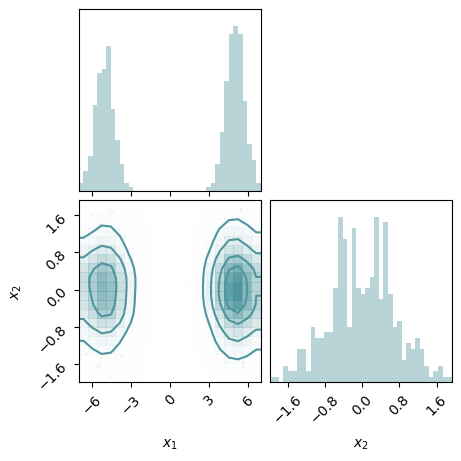

In [33]:
fig = plt.figure(figsize=(5,5))
params = {'color': '#4F959D',
            'hist_bin_factor': 2,
            'smooth': 1.5,
            "plot_datapoints": True,
            "plot_density": True,
            "plot_contours": True,
            "hist_kwargs": {"histtype":'stepfilled',"alpha":0.4},
          }
corner.corner(data = X.cpu().numpy(), labels=[r'$x_1$', r'$x_2$'],fig=fig,**params)
plt.show()

### Mixture of Six Gaussians

Here we create a mixture of six Gaussians where the means are spread around a circle of radius $5$and the covariance matrix is given by $\begin{pmatrix}0.5 & 0 \\ 0 & 0.5\end{pmatrix}$.

In [34]:
class MoG6(MoG):
  def __init__(self, device=None):
    def _compute_mu(i):
      return 5.0 * torch.Tensor([[
        torch.tensor(i * math.pi / 3.0).sin(),
        torch.tensor(i * math.pi / 3.0).cos()]])

    loc = torch.cat([_compute_mu(i) for i in range(1, 7)], dim=0).to(device)
    cov = torch.Tensor([0.5, 0.5]).diag().unsqueeze(0).to(device).repeat(6, 1, 1)

    super(MoG6, self).__init__(loc, cov)

mog6 = MoG6(device=device)

/home/usuario/Code/venv_gen/lib/python3.12/site-packages/torch/distributions/distribution.py:56: UserWarning: <class '__main__.MoG6'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


In [35]:
mog6.event_shape

torch.Size([2])

In [36]:
n = 400
X_init = (5 * torch.randn(n, *mog6.event_shape)).to(device)

X_init = (14 * torch.rand(n, *mog6.event_shape)-7).to(device)
X_init_np = X_init.cpu().numpy()

In [37]:
X = X_init.clone()
svgd = SVGD(mog6, K, optim.Adam([X], lr=1e-1))
for _ in range(1500):
    svgd.step(X)

In [38]:
mog6_chart = get_density_chart(mog6, d=7.0, step=0.1)

(mog6_chart + get_particles_chart(X_init.cpu().numpy())) | (mog6_chart + get_particles_chart(X.cpu().numpy()))

alt.HConcatChart(...)

## Mixture of Six Gaussians with One Particle

As we've noted in the blog post, using the one particle and a kernel where $\nabla_xk(x,x) = 0$, we achieve the classic MAP estimator. *rbf* kernel satisfies the gradient property. Let us see whether we get a MAP estimator. We should expect, just like in the classic mode-finding setting that the particle should end up in different modes for different runs.

In [39]:
X_init = (5 * torch.randn(1, *mog6.event_shape)).to(device)
X = X_init.clone()
svgd = SVGD(mog6, K, optim.Adam([X], lr=1e-1))

for _ in range(1000):
    svgd.step(X)

In [40]:
(mog6_chart + get_particles_chart(X_init.cpu().numpy())) | (mog6_chart + get_particles_chart(X.cpu().numpy()))

alt.HConcatChart(...)

In [ ]:
# Implement a distribution in Pytorch wich logpdf is given by the following function
# def logpdf(self, x):
#         return -10*(x[0]**2-x[1])**2 - (x[1]-1/4)**2

# Implement a distribution in Pytorch wich logpdf is given by the following function
# def logpdf(self, x):
#         return -10*(x[0]**2-x[1])**2 - (x[1]-1/4)**2

class UnnormalizedDistribution:
    def __init__(self, device=None):
        self.device = device if device else torch.device("cpu")
    
    def log_prob(self, x):
        """
        Compute the unnormalized log probability.
        
        Args:
            x (torch.Tensor): Input tensor of shape (..., 2), where each row is (x0, x1).
        
        Returns:
            torch.Tensor: Unnormalized log probability values.
        """
        x0, x1 = x[..., 0], x[..., 1]  # Extract coordinates
        return -10 * (x0**2 - x1) ** 2 - (x1 - 1/4) ** 2
    
    def prob(self, x):
        """
        Compute the unnormalized probability (exp of log_prob).
        
        Args:
            x (torch.Tensor): Input tensor of shape (..., 2).
        
        Returns:
            torch.Tensor: Unnormalized probability values.
        """
        return torch.exp(self.log_prob(x))
    
    def sample(self, num_samples):
        samples = torch.zeros((num_samples, 2), device=self.device)
        x = torch.randn(2, device=self.device)  # Initialize at a random point
        
        for i in range(num_samples):
            proposal = x + 0.1 * torch.randn(2, device=self.device)  # Gaussian proposal
            accept_ratio = torch.exp(self.log_prob(proposal) - self.log_prob(x))
            if torch.rand(1, device=self.device) < accept_ratio:
                x = proposal  # Accept the move
            samples[i] = x
        
        return samples

print()

In [68]:
n = 1000
dist = UnnormalizedDistribution(device=device)
X_init = (14* torch.rand(n, *gauss.event_shape)-7).to(device)

X = X_init.clone()
svgd = SVGD(dist, K, optim.Adam([X], lr=1e-1))
for _ in range(1000):
    svgd.step(X)

In [70]:
get_particles_chart(X.cpu().numpy())+get_density_chart(dist, d=7.0, step=0.1)

alt.LayerChart(...)

In [65]:
get_particles_chart(X_init.cpu().numpy())

alt.Chart(...)